# Example optimisation with stochastic nonlocal modifications and gradient descent

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
tic = time.time()

In [3]:
from ship_routing.core import Route, WayPoint
from ship_routing.data import (
    load_currents,
    load_winds,
    load_waves,
)
from ship_routing.convenience import (
    create_route, stochastic_search, gradient_descent, Logs, LogsRoute
)
from ship_routing.algorithms import (
    crossover_routes_minimal_cost,
    crossover_routes_random,
)

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import tqdm
from random import choice
import xarray as xr
import shapely

## Parameters

In [5]:
population_size = 1000

# reproducibility
random_seed = 345

# data sources
current_data_store = "/gxfs_work/geomar/smomw122/2024_ship_routing/ship_routing_data/data/cmems_mod_glo_phy_my_0.083deg_P1D-m_time_2021_lat_+10_+65_lon_-100_+010_uo-vo.zarr/"
wave_data_store = "/gxfs_work/geomar/smomw122/2024_ship_routing/ship_routing_data/data/cmems_mod_glo_wav_my_0.2deg_PT3H-i_time_2021_lat_+10_+65_lon_-100_+010_VHM0-VMDR.zarr/"
wind_data_store = "/gxfs_work/geomar/smomw122/2024_ship_routing/ship_routing_data/data/cmems_obs-wind_glo_phy_my_l4_0.125deg_PT1H_time_2021_lat_+10_+65_lon_-100_+010_eastward_wind-northward_wind.zarr/"

# initial route
lon_waypoints = [-80.5, -12.0]
lat_waypoints = [30.0, 45.0]
time_start = "2021-08-01T12:00"
time_end = None
speed_knots = 7.0  # either one time and speed or both times needed
time_resolution_hours = 12.0

# stochastic search parameters
stoch_num_generations = 4
stoch_number_of_iterations = 1
stoch_acceptance_rate_target = 0.01
stoch_warmup_acceptance_rate = 0.3

# experiment id
experiment_id = 2

scheduler_file =  None
dask_n_workers = 5

In [6]:
np.random.seed(random_seed)

## Define a route

In [7]:
route_0 = create_route(
    lon_waypoints=lon_waypoints,
    lat_waypoints=lat_waypoints,
    time_start=time_start,
    time_end=time_end,
    speed_knots=speed_knots,
    time_resolution_hours=time_resolution_hours,
)

route_0

Route(way_points=(WayPoint(lon=np.float64(-80.5), lat=np.float64(30.0), time=np.datetime64('2021-08-01T12:00:00')), WayPoint(lon=-79.21575362031135, lat=30.805756992465852, time=np.datetime64('2021-08-01T23:45:04.149')), WayPoint(lon=-77.91007287073641, lat=31.598477743602082, time=np.datetime64('2021-08-02T11:30:08.299')), WayPoint(lon=-76.58228001811983, lat=32.37753160291453, time=np.datetime64('2021-08-02T23:15:12.449')), WayPoint(lon=-75.2317181733898, lat=33.14226774921861, time=np.datetime64('2021-08-03T11:00:16.599')), WayPoint(lon=-73.85775640205404, lat=33.892015224837415, time=np.datetime64('2021-08-03T22:45:20.749')), WayPoint(lon=-72.45979537063289, lat=34.62608313731345, time=np.datetime64('2021-08-04T10:30:24.899')), WayPoint(lon=-71.03727353778287, lat=35.343761052265044, time=np.datetime64('2021-08-04T22:15:29.049')), WayPoint(lon=-69.58967388924779, lat=36.04431960224458, time=np.datetime64('2021-08-05T10:00:33.199')), WayPoint(lon=-68.11653120387712, lat=36.727011337

In [8]:
print("speed (m/s)", np.mean([l.speed_ms for l in route_0.legs]))

speed (m/s) 3.6011115271839906


## Load and plot currents, winds, waves

In [9]:
currents = load_currents(
    data_file=current_data_store,
    engine="zarr",
    chunks="auto",
)
currents["speed"] = ((currents.to_array() ** 2).sum("variable") ** 0.5).where(
    ~currents.uo.isnull()
)

currents

<xarray.HashableDataset> Size: 4GB
Dimensions:  (lat: 661, lon: 1321, time: 365)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 3kB 10.0 10.08 10.17 10.25 ... 64.75 64.83 64.92 65.0
  * lon      (lon) float32 5kB -100.0 -99.92 -99.83 -99.75 ... 9.833 9.917 10.0
  * time     (time) datetime64[ns] 3kB 2021-01-01 2021-01-02 ... 2021-12-31
Data variables:
    uo       (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>
    vo       (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>
    speed    (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>

In [10]:
winds = load_winds(
    data_file=wind_data_store,
    engine="zarr",
    chunks="auto",
)
winds["speed"] = ((winds.to_array() ** 2).sum("variable") ** 0.5).where(
    ~winds.uw.isnull()
)
winds = winds

In [11]:
waves = load_waves(
    data_file=wave_data_store,
    engine="zarr",
    chunks="auto",
)

waves = waves

## Subset for the route

In [12]:
%time currents = currents.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()
%time winds = winds.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()
%time waves = waves.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()

CPU times: user 963 ms, sys: 578 ms, total: 1.54 s
Wall time: 687 ms
CPU times: user 9.23 s, sys: 9.92 s, total: 19.1 s
Wall time: 2.06 s
CPU times: user 154 ms, sys: 76.3 ms, total: 230 ms
Wall time: 133 ms


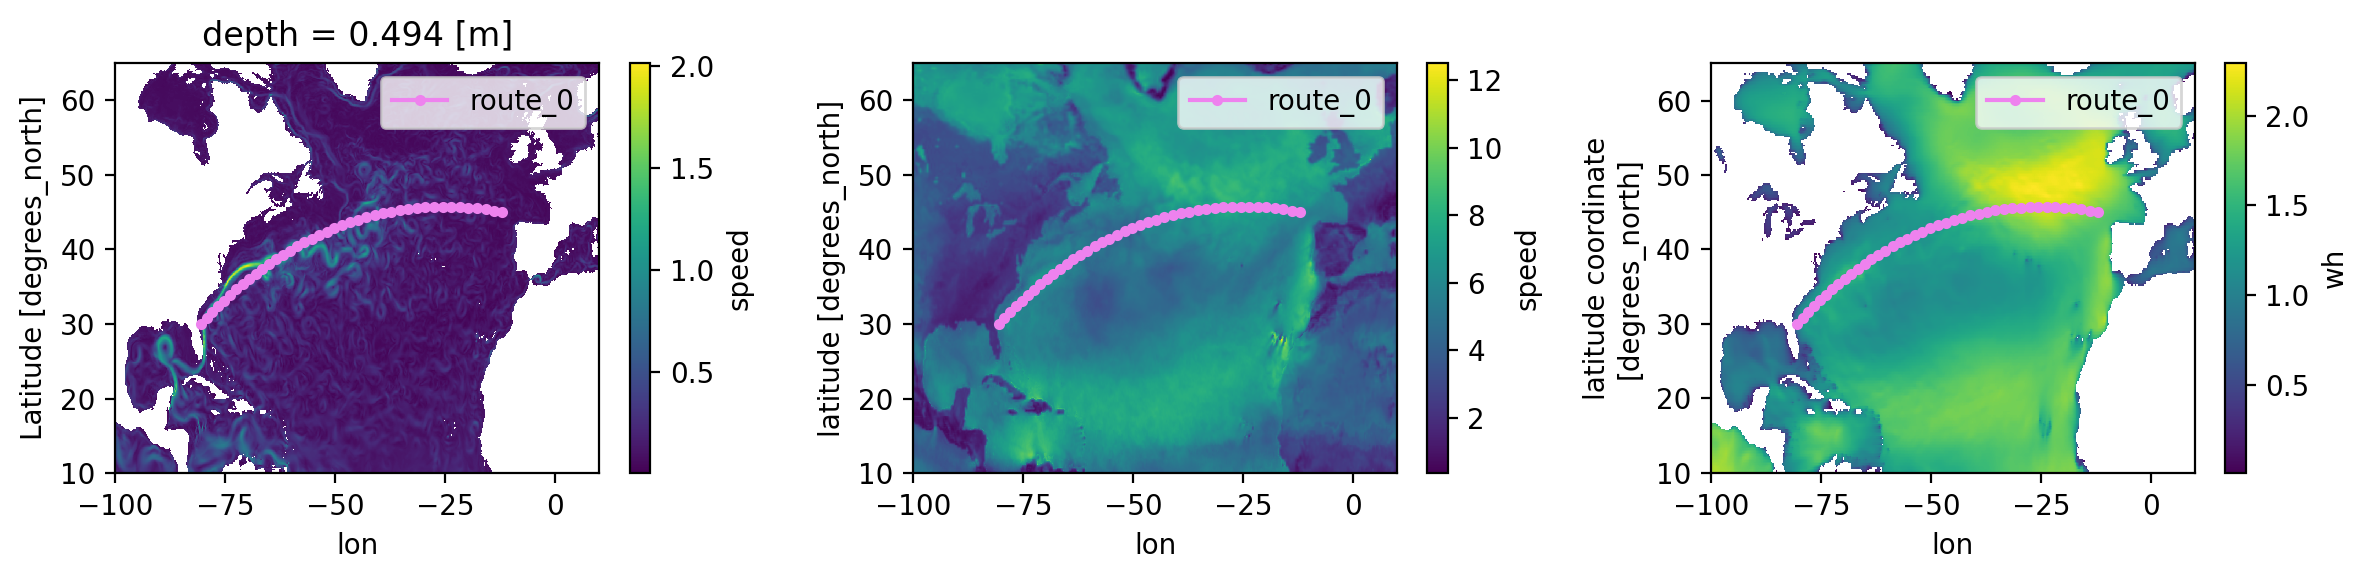

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(200)

currents.speed.mean("time").plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon", y="lat", marker=".", ax=_ax, color="violet", label="route_0"
    )

fig.tight_layout();

## Concurrency

In [14]:
from concurrent.futures import ProcessPoolExecutor

In [15]:
def distribute_ambient_fields(currents_in=None, winds_in=None, waves_in=None):
    global currents
    global winds
    global waves
    np.random.seed()
    currents = currents_in
    winds = winds_in
    waves = waves_in

In [32]:
executor = ProcessPoolExecutor(32, initializer=distribute_ambient_fields, initargs=(currents, winds, waves))
time.sleep(1.0)

In [33]:
list(executor.map(np.random.seed, range(32)));
time.sleep(1.0)

In [24]:
def stochastic_search_mproc(logs_routes, mod_width=None, max_move_meters=None, **kwargs):
    global currents
    global winds
    global waves
    route = logs_routes.route
    if mod_width is None:
        mod_width = np.random.uniform(0, 1) * route.length_meters
    if max_move_meters is None:
        max_move_meters = 0.75 * mod_width
    _route, _logs_routes = stochastic_search(
        route=route,
        mod_width=mod_width,
        max_move_meters=max_move_meters,
        current_data_set=currents,
        wind_data_set=winds,
        wave_data_set=waves,     
        **kwargs,
    )
    return _logs_routes[-1]

In [25]:
population = [LogsRoute(route=deepcopy(route_0), logs=None) for n in range(population_size)]

In [26]:
from functools import partial

In [27]:
#warmup
population = list(tqdm.tqdm(executor.map(
    partial(
        stochastic_search_mproc,
        acceptance_rate_for_increase_cost=1,
        acceptance_rate_target=0.1,
        number_of_iterations=1,
        mod_width=route_0.length_meters * 0.9,
        max_move_meters=route_0.length_meters * 0.2,
    ),
    population,
), total=population_size))

100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.19it/s]


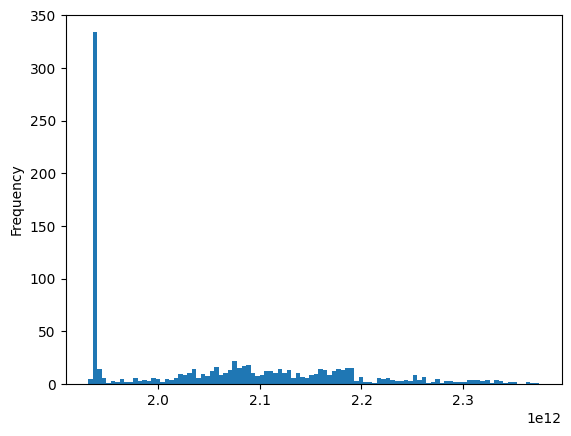

In [28]:
cost = [p.logs.cost for p in population]
pd.Series(cost).plot.hist(bins=100);

In [29]:
def crossover_mp(r0, r1):
    try:
        return crossover_routes_random(r0, r1)
    except:
        return r0

In [30]:
import random

In [34]:
population_cr = list(executor.map(crossover_mp, [p.route for p  in population], [p.route for p in random.choices(population, k=population_size)]))
population = [LogsRoute(route=pr, logs=None) for pr in population_cr]

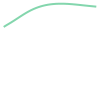

In [35]:
population_cr[22].line_string

In [36]:
# optimisation
population = list(tqdm.tqdm(executor.map(
    partial(
        stochastic_search_mproc,
        acceptance_rate_for_increase_cost=0,
        acceptance_rate_target=0.3,
        number_of_iterations=3,
    ),
    population,
), total=population_size))

100%|███████████████████████████████████████| 1000/1000 [01:38<00:00, 10.13it/s]


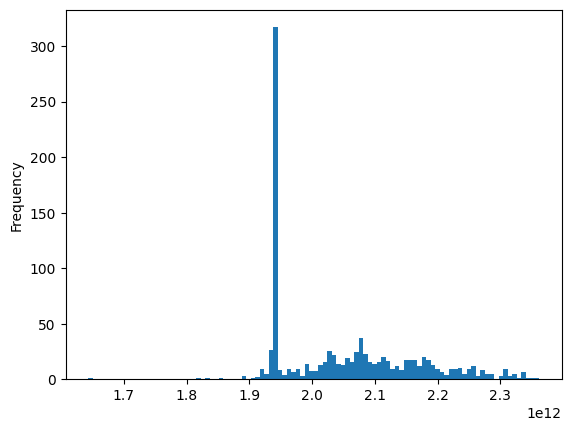

In [37]:
cost = [p.logs.cost for p in population]
pd.Series(cost).plot.hist(bins=100);

In [38]:
cthres = pd.Series(cost).quantile(0.5)
population = [p for p in population if p.logs.cost < cthres]
population = list(np.random.choice(population, size=(population_size, )))

In [39]:
# optimisation
population = list(tqdm.tqdm(executor.map(
    partial(
        stochastic_search_mproc,
        acceptance_rate_for_increase_cost=0,
        acceptance_rate_target=0.3,
        number_of_iterations=3,
    ),
    population,
), total=population_size))

100%|███████████████████████████████████████| 1000/1000 [01:20<00:00, 12.44it/s]


In [40]:
cr0 = route_0.cost_through(current_data_set=currents, wind_data_set=winds, wave_data_set=waves)

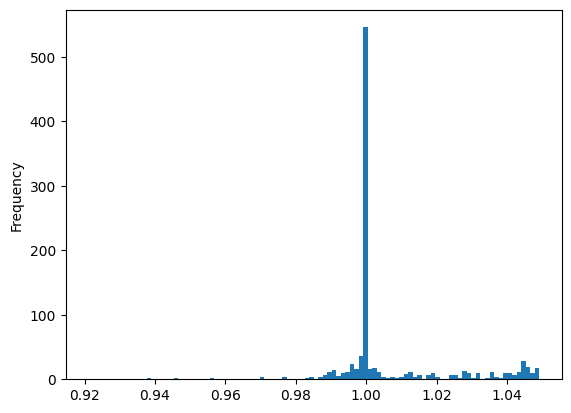

In [41]:
cost = [p.logs.cost for p in population]
(pd.Series(cost) / cr0).plot.hist(bins=100);

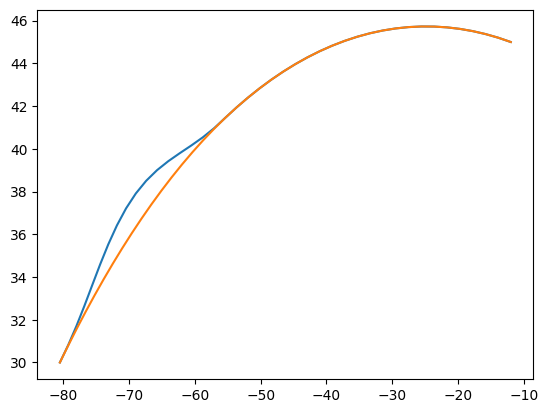

In [42]:
plt.plot(*sorted(population, key=lambda lr: lr.logs.cost)[0].route.line_string.xy)
plt.plot(*route_0.line_string.xy)